In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import wave as wv
import tensorflow as tf
import tensorflow_io as tfio
import json
import random
from IPython.display import clear_output, Audio
import librosa
import librosa.display
from pathlib import Path
from PIL import Image
import time
import pywt

In [2]:
# Init sound format
sample_path = "assets\\sample.wav"
spf = wv.open(sample_path, "rb")
sample_freq = spf.getframerate()
n_samples = spf.getnframes()
t_audio = n_samples/sample_freq

print(sample_freq, n_samples, t_audio)

final_sr = 8000

16000 16000 1.0


In [3]:
# def rgb_to_input_shape(arr):
#     d, x, y = arr.shape
#     if y != 3:
#         raise Exception("Input array has to be in RGB format")
#     out = []
#     for i in range(y):
#         grid = []
#         for j in range(d):
#             row = []
#             for k in range(x):
#                 row.append(arr[j][k][i])
#             grid.append(row)
#         out.append(grid)
#     return np.array(out)

def load_spectro_files(filepath, foldername, filename):
    samples, sample_rate = librosa.load(filepath, mono=True)
    samples = librosa.resample(y=samples, orig_sr=sample_rate, target_sr=final_sr)
    if (len(samples) == final_sr):
        filename = os.path.splitext(filename)[0]
        imagepath = f'assets/spectrograms/{foldername}/'
        isExist = os.path.exists(imagepath)
        if not isExist:
            os.makedirs(imagepath)
        os.system(f"arss -q {filepath} {imagepath + filename}.bmp --min-freq 27.500 --max-freq 7865.000 --pps 150 --bpo 100")
        img = np.array(Image.open(imagepath + filename + ".bmp").convert('L'))
        return img
    else:
        return None

def load_spectro(filepath, foldername, filename):
    filename = os.path.splitext(filename)[0]
    try:
        img = np.array(Image.open(f'assets/spectrograms/{foldername}/{filename}.bmp').convert('L'))
    except:
        os.system(f"arss -q {filepath} assets/spectrograms/{foldername}/{filename}.bmp --min-freq 27.500 --max-freq 7865.000 --pps 150 --bpo 100")
        img = np.array(Image.open(f"assets/spectrograms/{foldername}/{filename}.bmp").convert('L'))
    return img

def load_wav(filepath):
    samples, sample_rate = librosa.load(filepath, mono=True)
    samples = librosa.resample(y=samples, orig_sr=sample_rate, target_sr=final_sr)
    if (len(samples) == final_sr):
        return np.array(samples)
    else:
        return None

def load_mfcc(filepath, n_mfcc=20):
    samples, sr = librosa.load(filepath, mono=True)
    samples = librosa.resample(y=samples, orig_sr=sr, target_sr=final_sr)
    if (len(samples) == final_sr):
        mfccs = librosa.feature.mfcc(y=samples, sr=final_sr, n_mfcc=n_mfcc)
        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)
        return np.array([mfccs, delta_mfccs, delta2_mfccs])
    else:
        return None

In [12]:
%%time

# Only run if spectrograms is empty

data = []
encoding = {}
directory = 'assets/speech_commands/'
foldercnt = 0
for index, categoryname in enumerate(os.listdir(directory)):
    encoding[categoryname] = index
    categorypath = os.path.join(directory, categoryname)
    filecnt = 0
    foldercnt += 1
    for filename in os.listdir(categorypath):
        filepath = os.path.join(categorypath, filename)
        if not os.path.exists(f"assets/spectrograms/{categoryname}/{os.path.splitext(filename)[0]}.bmp"):
            print("doesn't exist")
            spectro = load_spectro_files(filepath, categoryname, filename)
            if spectro is not None:
                data.append({'label': categoryname, 'data': spectro})
        else:
            print("exists")
            spectro = load_spectro(filepath, categoryname, filename)
            if spectro is not None:
                data.append({'label': categoryname, 'data': spectro})
        if filecnt % 10 == 0:
            clear_output(wait=True)
            print(f"{foldercnt}/{len(os.listdir(directory))} folders | {filecnt}/{len(os.listdir(categorypath))} files - {round((filecnt/len(os.listdir(categorypath)))*100)}%")
        filecnt += 1

clear_output(wait=True)
print(f"{foldercnt}/{len(os.listdir(directory))} folders | {filecnt}/{len(os.listdir(categorypath))} files - {round(filecnt/len(os.listdir(categorypath)))}%")
print("FINISHED")

3/3 folders | 2376/2376 files - 1%
FINISHED
CPU times: total: 35.2 s
Wall time: 5min 37s


In [28]:
%%time

# Only run if spectrograms isn't empty

data = []
encoding = {}
directory = 'assets/spectrograms/'
foldercnt = 0
for index, categoryname in enumerate(os.listdir(directory)):
    encoding[categoryname] = index
    categorypath = os.path.join(directory, categoryname)
    filecnt = 0
    foldercnt += 1
    for filename in os.listdir(categorypath):
        filepath = os.path.join(categorypath, filename)
        spectro = load_spectro(filepath)
        data.append({'label': categoryname, 'data': spectro})
        if filecnt % 25 == 0:
            clear_output(wait=True)
            print(f"{foldercnt}/{len(os.listdir(directory))} folders | {filecnt}/{len(os.listdir(categorypath))} files - {round((filecnt/len(os.listdir(categorypath)))*100)}%")
        filecnt += 1

clear_output(wait=True)
print(f"{foldercnt}/{len(os.listdir(directory))} folders | {filecnt}/{len(os.listdir(categorypath))} files - {round(filecnt/len(os.listdir(categorypath)))}%")
print("FINISHED")

KeyboardInterrupt: 

In [6]:
%%time

# Only run if you want wave data

data = []
encoding = {}
directory = 'assets/speech_commands/'
foldercnt = 0
for index, categoryname in enumerate(os.listdir(directory)):
    encoding[categoryname] = index
    categorypath = os.path.join(directory, categoryname)
    filecnt = 0
    foldercnt += 1
    for filename in os.listdir(categorypath):
        filepath = os.path.join(categorypath, filename)
        wav = load_wav(filepath)
        if wav is not None:
            data.append({'label': categoryname, 'data': wav})
            if filecnt % 25 == 0:
                clear_output(wait=True)
                print(f"{foldercnt}/{len(os.listdir(directory))} folders | {filecnt}/{len(os.listdir(categorypath))} files - {round((filecnt/len(os.listdir(categorypath)))*100)}%")
            filecnt += 1

clear_output(wait=True)
print(f"{foldercnt}/{len(os.listdir(directory))} folders | {filecnt}/{len(os.listdir(categorypath))} files - {round(filecnt/len(os.listdir(categorypath)))}%")
print("FINISHED")
print(f"Number of datum: {len(data)}")

5/5 folders | 2203/2376 files - 1%
FINISHED
Number of datum: 10747
CPU times: total: 9min 26s
Wall time: 11min 17s


In [5]:
%%time

# Only run if you want mfcc data

data = []
encoding = {}
directory = 'assets/speech_commands/'
foldercnt = 0
for index, categoryname in enumerate(os.listdir(directory)):
    encoding[categoryname] = index
    categorypath = os.path.join(directory, categoryname)
    filecnt = 0
    foldercnt += 1
    for filename in os.listdir(categorypath):
        filepath = os.path.join(categorypath, filename)
        mfcc = load_mfcc(filepath)
        if mfcc is not None:
            data.append({'label': categoryname, 'data': mfcc})
            if filecnt % 25 == 0:
                clear_output(wait=True)
                print(f"{foldercnt}/{len(os.listdir(directory))} folders | {filecnt}/{len(os.listdir(categorypath))} files - {round((filecnt/len(os.listdir(categorypath)))*100)}%")
            filecnt += 1

clear_output(wait=True)
print(f"{foldercnt}/{len(os.listdir(directory))} folders | {filecnt}/{len(os.listdir(categorypath))} files - {round(filecnt/len(os.listdir(categorypath)))}%")
print("FINISHED")
print(f"Number of datum: {len(data)}")

3/3 folders | 2203/2376 files - 1%
FINISHED
Number of datum: 6446
CPU times: total: 41min 35s
Wall time: 7min 27s


In [6]:
%%time

# Only run if you want spectro data

data = []
encoding = {}
directory = 'assets/speech_commands/'
foldercnt = 0
for index, categoryname in enumerate(os.listdir(directory)):
    encoding[categoryname] = index
    categorypath = os.path.join(directory, categoryname)
    filecnt = 0
    foldercnt += 1
    for filename in os.listdir(categorypath):
        filepath = os.path.join(categorypath, filename)
        wav = load_wav(filepath)
        if wav is not None:
            spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
            spectrogram = tf.abs(spectrogram)
            spectrogram = tf.expand_dims(spectrogram, axis=2)
            data.append({'label': categoryname, 'data': spectrogram})
            if filecnt % 25 == 0:
                clear_output(wait=True)
                print(f"{foldercnt}/{len(os.listdir(directory))} folders | {filecnt}/{len(os.listdir(categorypath))} files - {round((filecnt/len(os.listdir(categorypath)))*100)}%")
            filecnt += 1
        if filecnt >= 1000:
            break

clear_output(wait=True)
print(f"{foldercnt}/{len(os.listdir(directory))} folders | {filecnt}/{len(os.listdir(categorypath))} files - {round(filecnt/len(os.listdir(categorypath)))}%")
print("FINISHED")
print(f"Number of datum: {len(data)}")

3/3 folders | 1000/2376 files - 0%
FINISHED
Number of datum: 3000
CPU times: total: 2min 13s
Wall time: 4min 22s


In [7]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, len(encoding)))
    decoded_Y = np.array([encoding[value] for value in Y])
    one_hot_Y[np.arange(Y.size), np.subtract(decoded_Y, 1)] = 1
    return np.reshape(one_hot_Y, (-1, len(encoding), 1))

def reshape2d(X):
    return X.reshape(-1, X.shape[1], 1)

def column(matrix, i):
    return [row[i] for row in matrix]

def init_params():
    n = len(data)
    random.shuffle(data)
    traindata = column(data, 'data')
    labeldata = column(data, 'label')
    print(n)
    ind = round(0.8*len(data))
    x_train = traindata[0:ind]
    y_train = labeldata[0:ind]
    x_test = traindata[ind:n]
    y_test = labeldata[ind:n]
    return np.array(x_train, dtype=np.ndarray), one_hot(np.array(y_train, dtype=np.ndarray)), np.array(x_test), one_hot(np.array(y_test))

x_train, y_train, x_test, y_test = init_params()
print("Created training and test sets")
# x_train = reshape2d(x_train) # only if working with 1d wave data
image_shape = x_train[0].shape
print(x_train.shape)
print(y_train.shape)

3000
Created training and test sets
(2400, 241, 257, 1)
(2400, 3, 1)


In [15]:
x_train = np.reshape(x_train, (2400, 1, 241, 257))

In [19]:
# view spectrogram
def view_spectro(index):
    print(y_train[index])
    print(x_train[index].shape)
    plt.imshow(data[index]['rgb'])
    plt.show()

# view wave data
def view_wave(index):
    label = list(encoding.keys())[list(encoding.values()).index(np.argmax(y_train[index]))]
    print(label)
    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_title(f"Raw wave data of someone saying \'{label}\'")
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Amplitude')
    ax1.plot(np.linspace(0, final_sr/len(x_train[index]), final_sr), x_train[index])
    plt.show()

# while True:
#     index = input(f"Enter an index between 0-{len(y_train)}: ")
#     if index == ' ':
#         index = random.randrange(0, len(y_train))
#     print(index)
#     clear_output(wait=True)
#     view_spectro(int(index))
#     # view_wave(int(index))

In [39]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate):
        # TODO: update parameters and return input gradient
        pass


class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        activation_output = self.activation_prime(self.input)
        return np.multiply(output_gradient, activation_output)


class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.input_shape = input_shape
        self.kernel_size = kernel_size
        self.depth = depth
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                res = signal.correlate(self.input[j], self.kernels[i, j], mode='valid')
                self.output[i] = np.add(self.output[i], res)
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                res = signal.correlate(self.input[j], output_gradient[i], mode='valid')
                kernels_gradient[i, j] = res
                input_gradient[j] = np.add(input_gradient[j], signal.convolve2d(output_gradient[i], self.kernels[i, j], mode='full'))

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

    def returnValues(self):
        return (self.kernels, self.biases)


class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient
    
    def returnValues(self):
        return (self.weights, self.bias)

class LSTM(Layer):
    def __init__(self, mem_cell_ct, input_shape):
        self.mem_cell_ct = mem_cell_ct
        self.input_shape = input_shape
        concat_len = input_shape + mem_cell_ct
        # weight matrices
        self.wg = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len)
        self.wi = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len) 
        self.wf = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len)
        self.wo = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len)

class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)


class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)


class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)

class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)
        
class ReLU(Activation):
    def __init__(self):
        def relu(x):
            return np.maximum(x, 0)

        def relu_prime(x):
            for index in range(len(x)):
                if x[index][0] > 0:
                    x[index][0] = 1
                else:
                    x[index][0] = 0
            return x

        super().__init__(relu, relu_prime)

def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

def categorical_cross_entropy(y_true, y_pred):
    y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)
    out = np.sum(y_true*y_pred_clipped)
    return -np.log(out)

def categorical_cross_entropy_prime(y_true, y_pred):
    y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)
    return -y_true/y_pred_clipped

In [41]:
def predict(network, inp):
    output = inp
    for layer in network:
        output = layer.forward(output)
    return output

def get_accuracy():
    correct = 0
    for x, y in zip(x_test, y_test):
        output = predict(network, x)
        if np.argmax(output) == np.argmax(y):
            correct += 1
    return correct/y_test.shape[0]

def store_model(network, accuracy):
    index = 0
    modelpath = f'assets/models/model{index}/'
    while not os.path.exists(modelpath):
        index += 1
    os.makedirs(modelpath)
    print(f"Storing to /assets/models/model{index}...")
    freq = {"Convolutional": 0, "Dense": 0}
    with open(modelpath + "data.json") as fd:
        network_data = {}
        for layer in network:
            layer_name = str(layer.__class__.__name__)
            if layer_name == "Convolutional":
                network_data[layer_name] = {'input_shape': layer.input_shape, 'kernel_size': layer.kernel_size, 'depth': layer.depth, 'input_depth': layer.input_depth, 'output_shape': layer.output_shape, 'kernels_shape': layer.kernels_shape}
            elif layer_name == "Dense":
                network_data[layer_name] = {'input_size': layer.input_size, 'output_size': layer.output_size}
            elif layer_name == "Reshape":
                network_data[layer_name] = {'input_shape': layer.input_shape, 'output_shape': layer.output_shape}
            else:
                network_data[layer_name] = None
            if freq.includes(layer_name):
                w, b = layer.returnValues()
                weight_name = layer_name + "Weight" + {freq[layer_name]} + ".json"
                bias_name = layer_name + "Bias" + {freq[layer_name]} + ".json"
                np.set_printoptions(threshold=np.inf, suppress=True, precision=6)
                with open(modelpath + weightname, "w") as fw:
                    fw.write(json.dumps(w))
                    fw.close()
                with open(modelpath + biasname, "w") as fb:
                    fb.write(json.dumps(b))
                    fb.close()
                freq[layer_name] += 1
        fd.write(json.dumps({"network": network_data, "accuracy": accuracy}))
        fd.close()

def load_model(index=1):
    modelpath = f'assets/models/model{index}/'
    if os.path.exists(modelpath):
        freq = {"Convolutional": 0, "Dense": 0}
        with open(modelpath + "data.json", "r") as fd:
            contents = json.load(fd)
            print(contents)
            print(type(contents))

def plot_values(plot_data, predictions, window):
    plot_data["accuracy"].append((np.array(predictions['results']).sum()/len(predictions['results']))*100)
    plot_data["confidence"].append(np.mean(np.array(predictions['confidences'])))
    plot_data["loss"].append(np.mean(np.array(predictions['losses'])))
    plt.plot(plot_data["accuracy"][-window:], label="acc")
    plt.plot(plot_data["confidence"][-window:], label="conf")
    plt.plot(plot_data["loss"][-window:], label="loss")
    if (len(plot_data["accuracy"]) > 1):
        indices = np.array(list(range(len(plot_data["accuracy"][-window:]))))
        m1, b1 = np.polyfit(indices, plot_data["accuracy"][-window:], 1)
        m2, b2 = np.polyfit(indices, plot_data["confidence"][-window:], 1)
        m3, b3 = np.polyfit(indices, plot_data["loss"][-window:], 1)
        plt.plot(indices, np.add(np.multiply(m1, indices), b1), label='acc_fit', linestyle='dashed')
        plt.plot(indices, np.add(np.multiply(m2, indices), b2), label='conf_fit', linestyle='dashed')
        plt.plot(indices, np.add(np.multiply(m3, indices), b3), label='loss_fit', linestyle='dashed')
    plt.legend()
    plt.xlabel('Batch #')
    plt.ylabel('Percentage %')
    plt.show()

def train(network, loss, loss_prime, x_train, y_train, epochs = 1, learning_rate = 0.01):
    plot_data = {"accuracy": [], "confidence": [], "loss": []}
    window = 50
    batch_size = 25
    for e in range(epochs):
        error = 0
        predictions = {"results": [], "confidences": [], "losses": []}
        frequency = {0: 0, 1: 0, 2: 0}
        cnt = 0
        for x, y in zip(x_train, y_train):
            output = predict(network, x)
            # print("----------OUTPUT----------")
            # print("PREDICTION:", output)
            # print("LABEL:", y)
            frequency[np.argmax(output)] += 1
            if np.argmax(output) == np.argmax(y):
                # print("CORRECT! |", np.argmax(output), "-", np.argmax(y), "|", "CONFIDENCE: " + str(round(output[y.tolist().index([1])][0]*10000)/100) + "%")
                predictions["results"].append(True)
            else:
                # print("INCORRECT! |", np.argmax(output), "-", np.argmax(y), "|", "CONFIDENCE: " + str(round(output[y.tolist().index([1])][0]*10000)/100) + "%")
                predictions["results"].append(False)
            predictions["confidences"].append(round(output[y.tolist().index([1])][0]*10000)/100)
            
            res = loss(y, output)
            predictions["losses"].append(res)
            error += res
            # print("----------LOSS----------")
            # print("LOSS:", res)
            # print("ERROR:", error)
            
            grad = loss_prime(y, output)
            # print("----------GRADIENT----------")
            # print(grad)
            
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)
            cnt += 1
            if cnt % batch_size == 0:
                clear_output(wait=True)
                print(f"======EPOCH #{e+1}======\n{cnt}/{len(y_train)} datum | {round((cnt/len(y_train))*100)}%")
                print(f"BATCH: {np.array(predictions['results']).sum()}/{len(predictions['results'])} - ACC: {round((np.array(predictions['results']).sum()/len(predictions['results']))*100)}% - LOSS: {np.mean(np.array(predictions['losses']))} - CONF: {round(np.mean(np.array(predictions['confidences'])))}%")
                print("FREQ:", frequency)
                plot_values(plot_data, predictions, window)
                predictions = {"results": [], "confidences": [], "losses": []}
                frequency = {0: 0, 1: 0, 2: 0}
        error /= len(x_train)
        acc = get_accuracy()

======EPOCH #1======
100/2400 datum | 4%
BATCH: 7/25 - ACC: 28% - LOSS: 2.9552660098117642 - CONF: 29%
FREQ: {0: 9, 1: 5, 2: 11}


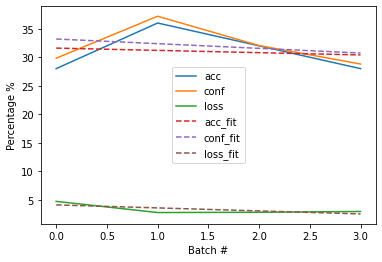

KeyboardInterrupt: 

In [42]:
network = [
    Convolutional((1, 241, 257), 3, 1),
    Sigmoid(),
    Reshape((1, 239, 255), (1 * 239 * 255, 1)),
    Dense(1 * 239 * 255, 100),
    Sigmoid(),
    Dense(100, 3),
    Softmax()
]
# network = [
#     Convolutional((3, 151, 232), 3, 3),
#     Sigmoid(),
#     Convolutional((3, 149, 230), 3, 3),
#     Sigmoid(),
#     Reshape((3, 147, 228), (3 * 147 * 228, 1)),
#     Dense(3 * 147 * 228, 100),
#     Sigmoid(),
#     Dense(100, 3),
#     Softmax()
# ]
# network = [
#     Convolutional((4, 20, 32), 3, 3),
#     Sigmoid(),
#     Convolutional((3, 18, 30), 3, 3),
#     Sigmoid(),
#     Reshape((3, 16, 28), (3 * 16 * 28, 1)),
#     Dense(3 * 16 * 28, 100),
#     Sigmoid(),
#     Dense(100, 50),
#     Sigmoid(),
#     Dense(50, 3),
#     Softmax()
# ]

# np.set_printoptions(threshold=np.inf, suppress=True)
# with open(r"data.txt", "w") as fw:
#     np.set_printoptions(precision=4)
#     fw.write(repr(x_train[0]))

train(network, categorical_cross_entropy, categorical_cross_entropy_prime, x_train, y_train, epochs=25, learning_rate=0.1)

# w1, b1 = network[0].returnValues()
# w2, b2 = network[2].returnValues()
# w3, b3 = network[5].returnValues()
# w4, b4 = network[7].returnValues()
# np.set_printoptions(threshold=np.inf, suppress=True)
# with open(r"weights.txt", "w") as fw:
#     np.set_printoptions(precision=4)
#     fw.write("W1:\n" + repr(w1))
#     fw.write("\nW2:\n" + repr(w2))
#     fw.write("\nW3:\n" + repr(w3))
#     fw.write("\nW4:\n" + repr(w4))
#     fw.close()

# with open(r"biases.txt", "w") as fb:
#     np.set_printoptions(precision=4)
#     fb.write("b1:\n" + repr(b1))
#     fb.write("\nb2:\n" + repr(b2))
#     fb.write("\nb3:\n" + repr(b3))
#     fb.write("\nb4:\n" + repr(b4))
#     fb.close()

In [13]:
correct = 0
cnt = 0
for x, y in zip(x_test, y_test):
    output = predict(network, x)
    print(f"pred: {np.argmax(output)} | true: {np.argmax(y)} | {cnt}/{len(y_test)} tests - {round((cnt/len(y_test))*100)}%")
    if np.argmax(output) == np.argmax(y):
        correct += 1
    cnt += 1


print("Accuracy:", correct/len(y_test))

C:\Users\Danie\AppData\Local\Temp\ipykernel_32896\2857242933.py:116: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


pred: 2 | true: 2 | 0/1277 tests - 0%
pred: 2 | true: 2 | 1/1277 tests - 0%
pred: 0 | true: 1 | 2/1277 tests - 0%
pred: 2 | true: 2 | 3/1277 tests - 0%
pred: 1 | true: 1 | 4/1277 tests - 0%
pred: 1 | true: 1 | 5/1277 tests - 0%
pred: 1 | true: 1 | 6/1277 tests - 0%
pred: 0 | true: 0 | 7/1277 tests - 1%
pred: 0 | true: 0 | 8/1277 tests - 1%
pred: 1 | true: 0 | 9/1277 tests - 1%
pred: 2 | true: 2 | 10/1277 tests - 1%
pred: 1 | true: 0 | 11/1277 tests - 1%
pred: 1 | true: 1 | 12/1277 tests - 1%
pred: 0 | true: 0 | 13/1277 tests - 1%
pred: 0 | true: 0 | 14/1277 tests - 1%
pred: 2 | true: 2 | 15/1277 tests - 1%
pred: 2 | true: 2 | 16/1277 tests - 1%
pred: 1 | true: 1 | 17/1277 tests - 1%
pred: 1 | true: 2 | 18/1277 tests - 1%
pred: 2 | true: 2 | 19/1277 tests - 1%
pred: 1 | true: 1 | 20/1277 tests - 2%
pred: 0 | true: 0 | 21/1277 tests - 2%
pred: 2 | true: 2 | 22/1277 tests - 2%
pred: 1 | true: 1 | 23/1277 tests - 2%
pred: 0 | true: 0 | 24/1277 tests - 2%
pred: 2 | true: 2 | 25/1277 tests -

In [23]:
def test_prediction(index):
    current_spec = x_test[index]
    prediction = predict(network, current_spec)
    label = y_test[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

while True:
    index = input(f"Enter an index between 0-{len(y_test)}: ")
    if index == ' ':
        index = random.randrange(0, len(y_test))
    print(index)
    clear_output(wait=True)
    test_prediction(int(index))

ValueError: invalid literal for int() with base 10: ''